In [127]:
%load_ext autoreload
%autoreload 2

import os

subj = "phase2/Subj15"

UNIQUE_VALUES_THRESHOLD = 200

exp = "exp_reduced_flow"
os.makedirs(f"{subj}/{exp}", exist_ok = True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
import typing

import mne
import numpy
import pandas
import IPython.display
import sklearn.metrics
import sklearn.preprocessing
import sklearn.decomposition
import matplotlib.pyplot as plt

import SDA.topology
import SDA.analytics
import SDA.clustquality
import SDA.stageprocess

### Data

Reading d:\HSE\year-3\HSE\CourseProject\phase2\Subj15\src\epochs_filt_rr-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     498.00 ms
        0 CTF compensation matrices available
Not setting metadata
1197 matching events found
No baseline correction applied
0 projection items activated
Stages:  5
No projector specified for this dataset. Please consider the method self.add_proj.


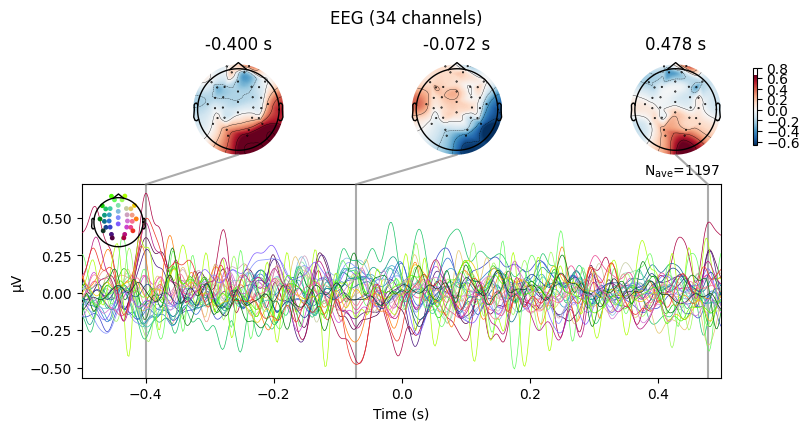

(1197, 34, 500)


In [129]:
epochs = mne.read_epochs(f"{subj}/src/epochs_filt_rr-epo.fif").drop_channels(ch_names = [ 'IVEOG', 'IHEOG' ])
N_STAGES = int(numpy.loadtxt(f"{subj}/src/n_stages.txt"))
print('Stages: ', N_STAGES)

epochs.average().plot_joint().savefig(f"{subj}/{exp}/eeg.svg")
data = epochs.get_data(copy = True)
print(data.shape)

### Features

In [130]:
per_channel_folder = f"{subj}/{exp}/features/per_channel"
os.makedirs(per_channel_folder, exist_ok = True)
per_channel_extractor = SDA.topology.PerChannelFeatureExtractor(n_jobs = -1, folder = per_channel_folder, reduced = True)
per_channel_features = per_channel_extractor.extract(data)

dissimilarity_folder = f"{subj}/{exp}/features/dissimilarity"
os.makedirs(dissimilarity_folder, exist_ok = True)
dissimilarity_extractor = SDA.topology.DissimilarityFeatureExtractor(n_jobs = -1, folder = dissimilarity_folder, reduced = True)
dissimilarity_features = dissimilarity_extractor.extract(data)

overall_folder = f"{subj}/{exp}/features/overall"
os.makedirs(overall_folder, exist_ok = True)
overall_extractor = SDA.topology.OverallFeatureExtractor(n_jobs = -1, folder = overall_folder, reduced = True)
overall_features = overall_extractor.extract(data)

all_features = pandas.concat([
    per_channel_features,
    dissimilarity_features,
    overall_features
], axis = 1)

all_features.to_feather(f"{subj}/{exp}/features/all_features.feather")
display(all_features)

Got features from phase2/Subj15/exp_reduced_flow/features/per_channel/features.feather
Got features from phase2/Subj15/exp_reduced_flow/features/overall/features.feather


,channel-0 landscape dim-1 max,channel-0 landscape dim-1 mean,channel-0 landscape dim-1 std,channel-0 landscape dim-1 sum,channel-0 landscape dim-1 norm-1,channel-0 landscape dim-1 norm-2,channel-0 landscape dim-2 max,channel-0 landscape dim-2 mean,channel-0 landscape dim-2 std,channel-0 landscape dim-2 sum,...,overall bd2 dim-2 std,overall bd2 dim-2 sum,overall bd2 dim-2 norm-1,overall bd2 dim-2 norm-2,overall bd2 dim-3 max,overall bd2 dim-3 mean,overall bd2 dim-3 std,overall bd2 dim-3 sum,overall bd2 dim-3 norm-1,overall bd2 dim-3 norm-2
0,4.042764e-07,4.587387e-09,4.053408e-08,4.587387e-07,4.587387e-07,4.079284e-07,2.093933e-07,2.370846e-09,2.098816e-08,2.370846e-07,...,0.000001,0.004333,0.004333,0.000459,0.000053,0.000051,1.057996e-06,0.002844,0.002844,0.000380
1,5.207366e-07,9.889221e-09,6.126498e-08,9.889221e-07,9.889221e-07,6.205799e-07,9.347294e-08,9.347294e-10,9.300440e-09,9.347294e-08,...,0.000006,0.001902,0.001902,0.000323,0.000066,0.000060,4.880625e-06,0.000956,0.000956,0.000240
2,9.174326e-07,1.795343e-08,1.094330e-07,1.795343e-06,1.795343e-06,1.108959e-06,2.768858e-07,2.768858e-09,2.754979e-08,2.768858e-07,...,0.000003,0.001716,0.001716,0.000314,0.000065,0.000059,3.581721e-06,0.000296,0.000296,0.000133
3,5.251110e-07,1.042644e-08,7.298703e-08,1.042644e-06,1.042644e-06,7.372800e-07,2.931085e-07,2.931085e-09,2.916393e-08,2.931085e-07,...,0.000006,0.001520,0.001520,0.000289,0.000055,0.000052,1.652381e-06,0.000210,0.000210,0.000105
4,7.048794e-07,8.854583e-09,7.222350e-08,8.854583e-07,8.854583e-07,7.276426e-07,1.324723e-07,2.304315e-09,1.631378e-08,2.304315e-07,...,0.000004,0.001655,0.001655,0.000289,0.000051,0.000051,1.817940e-07,0.000254,0.000254,0.000114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,6.338804e-07,1.862399e-08,9.397028e-08,1.862399e-06,1.862399e-06,9.579805e-07,2.879904e-07,4.008271e-09,3.056159e-08,4.008271e-07,...,0.000008,0.001455,0.001455,0.000288,0.000075,0.000058,5.159215e-06,0.000697,0.000697,0.000202
1193,1.572930e-06,3.035176e-08,1.803564e-07,3.035176e-06,3.035176e-06,1.828925e-06,1.220091e-07,2.361182e-09,1.653771e-08,2.361182e-07,...,0.000017,0.001080,0.001080,0.000278,0.000063,0.000062,6.612078e-07,0.000187,0.000187,0.000108
1194,1.116838e-06,1.557159e-08,1.152230e-07,1.557159e-06,1.557159e-06,1.162704e-06,2.016602e-07,3.523574e-09,2.492688e-08,3.523574e-07,...,0.000015,0.000487,0.000487,0.000188,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
1195,5.539916e-06,3.017999e-07,9.916002e-07,3.017999e-05,3.017999e-05,1.036511e-05,1.474524e-07,1.948364e-09,1.536485e-08,1.948364e-07,...,0.000005,0.000361,0.000361,0.000181,0.000089,0.000089,0.000000e+00,0.000089,0.000089,0.000089


In [131]:
features = sklearn.preprocessing.StandardScaler().fit_transform(all_features)
features = pandas.DataFrame(features, columns = all_features.columns)

features.to_feather(f"{subj}/{exp}/features/features.feather")
display(features)

numpy.save(f"{subj}/{exp}/features/features.npy", features.to_numpy())

,channel-0 landscape dim-1 max,channel-0 landscape dim-1 mean,channel-0 landscape dim-1 std,channel-0 landscape dim-1 sum,channel-0 landscape dim-1 norm-1,channel-0 landscape dim-1 norm-2,channel-0 landscape dim-2 max,channel-0 landscape dim-2 mean,channel-0 landscape dim-2 std,channel-0 landscape dim-2 sum,...,overall bd2 dim-2 std,overall bd2 dim-2 sum,overall bd2 dim-2 norm-1,overall bd2 dim-2 norm-2,overall bd2 dim-3 max,overall bd2 dim-3 mean,overall bd2 dim-3 std,overall bd2 dim-3 sum,overall bd2 dim-3 norm-1,overall bd2 dim-3 norm-2
0,-0.950271,-0.857508,-0.995585,-0.857508,-0.857508,-0.989246,0.565802,0.352323,0.471524,0.352323,...,-0.576106,1.714432,1.714432,1.307645,-0.292404,-0.215290,-0.556415,2.522828,2.522828,1.860216
1,-0.721616,-0.536841,-0.703775,-0.536841,-0.536841,-0.697424,-0.391205,-0.503254,-0.436355,-0.503254,...,0.226825,-0.244255,-0.244255,-0.058049,0.412507,0.335903,0.739917,0.120834,0.120834,0.440397
2,0.057249,-0.049099,-0.025756,-0.049099,-0.049099,-0.027223,1.123001,0.589441,0.981218,0.589441,...,-0.243539,-0.394157,-0.394157,-0.154406,0.375999,0.302476,0.299432,-0.719079,-0.719079,-0.644482
3,-0.713027,-0.504348,-0.538774,-0.504348,-0.504348,-0.537277,1.256931,0.686089,1.106601,0.686089,...,0.200717,-0.552394,-0.552394,-0.405383,-0.216003,-0.117133,-0.354847,-0.829209,-0.829209,-0.926230
4,-0.360074,-0.599418,-0.549522,-0.599418,-0.599418,-0.550503,-0.069237,0.312687,0.108427,0.312687,...,-0.134032,-0.443379,-0.443379,-0.403947,-0.411352,-0.209349,-0.853554,-0.772111,-0.772111,-0.835579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,-0.499471,-0.008542,-0.243411,-0.008542,-0.008542,-0.234410,1.214677,1.327830,1.215169,1.327830,...,0.537227,-0.604369,-0.604369,-0.413004,0.931277,0.234840,0.834392,-0.208461,-0.208461,0.058496
1193,1.344238,0.700781,0.972570,0.700781,0.700781,0.960785,-0.155618,0.346566,0.125822,0.346566,...,2.115467,-0.906369,-0.906369,-0.512719,0.249802,0.502126,-0.690974,-0.857364,-0.857364,-0.891956
1194,0.448757,-0.193158,0.055744,-0.193158,-0.193158,0.046532,0.501959,1.039069,0.777476,1.039069,...,1.917664,-1.384686,-1.384686,-1.412578,-3.294227,-3.333551,-0.915204,-1.095820,-1.095820,-1.987145
1195,9.132934,17.118591,12.391730,17.118591,17.118591,12.674966,0.054435,0.100626,0.034716,0.100626,...,-0.021986,-1.486307,-1.486307,-1.492174,1.728449,2.144151,-0.915204,-0.982308,-0.982308,-1.084202


### Feature selection

In [132]:
os.makedirs(f"{subj}/{exp}/qsda", exist_ok = True)
qsda = SDA.QSDA(
    n_jobs = 1,
    qsda_n_jobs = 15,
    scores_folder = f"{subj}/{exp}/qsda",

    threshold = 1150,
    min_unique_values = UNIQUE_VALUES_THRESHOLD
)
best_features, scores = qsda.select(features)

best_features.to_feather(f"{subj}/{exp}/qsda/best_features.feather")
numpy.save(f"{subj}/{exp}/qsda/best_features.npy", features.to_numpy())
display(best_features)
display(scores)

Using threshold 0.23


,channel-0 landscape dim-1 mean,channel-0 landscape dim-1 sum,channel-0 landscape dim-1 norm-1,channel-0 silhouette-1 dim-1 mean,channel-0 silhouette-1 dim-1 std,channel-0 silhouette-1 dim-1 sum,channel-0 silhouette-1 dim-1 norm-1,channel-0 silhouette-1 dim-1 norm-2,channel-0 silhouette-2 dim-1 mean,channel-0 silhouette-2 dim-1 sum,...,overall life all norm-2,overall life dim-1 norm-2,overall bd2 all max,overall bd2 dim-1 max,overall bd2 dim-1 std,overall bd2 dim-1 sum,overall bd2 dim-1 norm-1,overall bd2 dim-1 norm-2,overall bd2 dim-2 max,overall bd2 dim-2 std
0,-0.857508,-0.857508,-0.857508,-0.580915,-0.729754,-0.580915,-0.580915,-0.723342,-0.518340,-0.518340,...,-0.193938,-0.233452,-0.672269,-0.701521,-0.937925,0.968719,0.968719,0.681368,-0.643638,-0.576106
1,-0.536841,-0.536841,-0.536841,-0.393022,-0.444216,-0.393022,-0.393022,-0.441893,-0.430108,-0.430108,...,0.208745,0.226867,-0.027674,-0.231934,-0.101992,-0.596492,-0.596492,-0.646370,0.057848,0.226825
2,-0.049099,-0.049099,-0.049099,-0.263342,-0.413257,-0.263342,-0.263342,-0.407870,-0.293840,-0.293840,...,1.817271,1.823170,-0.061058,0.052164,-0.254724,0.167856,0.167856,0.331038,0.019017,-0.243539
3,-0.504348,-0.504348,-0.504348,-0.297450,-0.328645,-0.297450,-0.297450,-0.327367,-0.359838,-0.359838,...,0.264980,0.314308,-0.149089,-0.055262,-0.012795,0.951962,0.951962,0.968030,0.007419,0.200717
4,-0.599418,-0.599418,-0.599418,-0.409938,-0.433233,-0.409938,-0.409938,-0.431707,-0.418301,-0.418301,...,0.847536,0.917508,-0.228592,-0.041341,-0.160102,0.383652,0.383652,0.306425,-0.141666,-0.134032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,-0.008542,-0.008542,-0.008542,-0.041580,-0.059363,-0.041580,-0.041580,-0.059221,-0.230186,-0.230186,...,-1.619318,-1.643779,0.498524,0.552934,0.271037,-0.264525,-0.264525,-0.007235,0.757074,0.537227
1193,0.700781,0.700781,0.700781,0.642948,0.958350,0.642948,0.642948,0.945072,0.365994,0.365994,...,-1.740453,-1.759090,2.341283,2.478424,1.814247,-1.025802,-1.025802,-0.364596,2.890187,2.115467
1194,-0.193158,-0.193158,-0.193158,-0.171256,-0.052846,-0.171256,-0.171256,-0.056993,-0.176596,-0.176596,...,-1.148205,-1.114811,1.286488,1.483037,1.809761,-1.394912,-1.394912,-0.874500,1.669193,1.917664
1195,17.118591,17.118591,17.118591,21.167718,16.056566,21.167718,21.167718,16.350308,16.525776,16.525776,...,-0.313595,-0.254690,4.754618,5.151104,4.210773,-1.309078,-1.309078,0.207727,2.025077,-0.021986


,name,score,mean,variance,unique_values,normalized_score
0,channel-0 landscape dim-1 max,1.095385,-2.181491e-16,1.0,1197,0.173895
1,channel-0 landscape dim-1 mean,1.495157,-2.968015e-17,1.0,1197,0.241250
2,channel-0 landscape dim-1 std,1.256457,-2.982855e-16,1.0,1197,0.201033
3,channel-0 landscape dim-1 sum,1.495157,-1.484007e-17,1.0,1197,0.241250
4,channel-0 landscape dim-1 norm-1,1.495157,-1.484007e-17,1.0,1197,0.241250
...,...,...,...,...,...,...
4167,overall bd2 dim-3 mean,1.031630,5.639228e-17,1.0,1143,0.163153
4168,overall bd2 dim-3 std,0.574698,-2.968015e-17,1.0,1083,0.086168
4169,overall bd2 dim-3 sum,0.676141,2.968015e-17,1.0,1143,0.103259
4170,overall bd2 dim-3 norm-1,0.676141,2.968015e-17,1.0,1143,0.103259


### Results

#### Estimator

In [133]:
def analyze(all_features: pandas.DataFrame, n_components: int, folder: str):
    folder = f"{subj}/{exp}/results/{folder}"
    os.makedirs(folder, exist_ok = True)

    # Scale features
    all_features = sklearn.preprocessing.StandardScaler().fit_transform(all_features)
    print(all_features.shape)
    numpy.save(f"{folder}/all_features.npy", all_features)
    numpy.savetxt(f"{folder}/all_features_shape.txt", all_features.shape)

    # PCA
    pca = sklearn.decomposition.PCA(n_components = n_components, svd_solver = "full", random_state = 42)
    pca_features = pca.fit_transform(all_features)
    print(pca_features.shape)
    numpy.save(f"{folder}/pca_features.npy", pca_features)
    numpy.savetxt(f"{folder}/pca_features_shape.txt", pca_features.shape)
    
    print('Explained variance', round(pca.explained_variance_ratio_.sum(), 2))
    print([ round(x, 3) for x in pca.explained_variance_ratio_ ])
    numpy.savetxt(f"{folder}/explained_variance.txt", [ pca.explained_variance_ratio_.sum() ])
    numpy.savetxt(f"{folder}/explained_variance_ratios.txt", pca.explained_variance_ratio_)

    # SDA
    sda = SDA.SDA(n_jobs = -1, scale = False, verbose = True)
    results, df_st_edges = sda.apply(pca_features)
    
    results.to_csv(f"{folder}/results.csv")
    df_st_edges.to_csv(f"{folder}/df_st_edges.csv")

    # Analyze
    best_results = SDA.analytics.best_results(results, key = 'Avg-Silh')
    best_results.to_csv(f"{folder}/best_results.csv")
    
    best_result = SDA.analytics.best_result(results, key = 'Avg-Silh', n_stages = N_STAGES)
    best_result_df = pandas.DataFrame([ best_result ])
    best_result_df.to_csv(f"{folder}/best_result.csv")
    display(best_result_df)
    
    best_edges = numpy.array(best_result['St_edges'])
    numpy.savetxt(f"{folder}/best_edges.txt", best_edges, fmt = "%d", newline = ' ')
    display(best_edges)

    stage_timing = SDA.analytics.stage_timing(best_edges, epochs)
    stage_timing.to_csv(f"{folder}/stage_timing.csv")
    display(stage_timing)
    
    SDA.analytics.plot_stats(pca_features, epochs, best_result, df_st_edges).savefig(f"{folder}/stats.svg")

#### Традиционные признаки

(1197, 341)
(1197, 15)
Explained variance 0.68
[0.245, 0.119, 0.083, 0.038, 0.035, 0.028, 0.026, 0.02, 0.018, 0.016, 0.013, 0.012, 0.011, 0.01, 0.01]
Applying to 1197 samples with 15 features each


stage 2: 100%|██████████| 672/672 [00:11<00:00, 56.13it/s]


,St_len_min,K_nb_max,N_cl_max,Cl_cen,Len_min,St_edges,N_stages,Longest_stage,Shortest_stage,Avg_stage_length,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold
0,40,35,10,Mode,40,"[0, 236, 426, 837, 1144, 1197]",5,411,53,239.4,9765.027573,9.344175,0.045495,84.222791,3.847444,0.122723,55.075639,3.255632


array([   0,  236,  426,  837, 1144, 1197])

,0,1,2,3,4
"Start-end time, sec","(5.5, 251.5)","(252.5, 459.5)","(460.5, 898.5)","(900.5, 1223.5)","(1224.5, 1281.5)"
"Time length, sec",246.0,207.0,438.0,323.0,57.0
Number of epochs,236,190,411,307,53


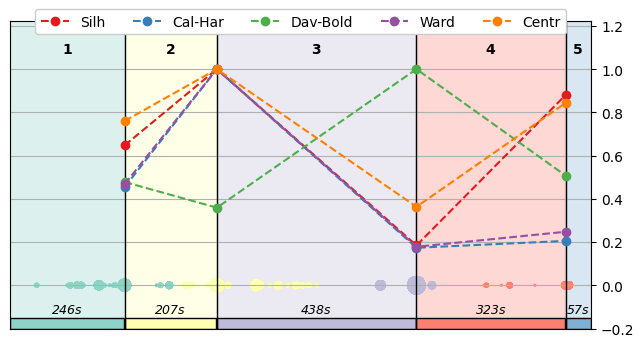

In [134]:
def read_traditional():
    df_ft_psd_loc_db = pandas.read_feather(f'{subj}/src/df_ft_psd_loc_db.feather')
    df_ft_psd_ind_loc_log = pandas.read_feather(f'{subj}/src/df_ft_psd_ind_loc_log.feather')
    df_ft_coh_ind_loc = pandas.read_feather(f'{subj}/src/df_ft_coh_ind_loc.feather')
    df_ft_plv_ind_loc = pandas.read_feather(f'{subj}/src/df_ft_plv_ind_loc.feather')

    result =  pandas.concat([
        df_ft_psd_loc_db,
        df_ft_psd_ind_loc_log,
        df_ft_coh_ind_loc,
        df_ft_plv_ind_loc
    ], axis = 1)

    if subj == "Subj2":
        result = result[:-2]
    return result

analyze(read_traditional(), 15, "traditional")

#### Топологические признаки + QSDA + PCA

(1197, 1189)
(1197, 15)
Explained variance 0.66
[0.166, 0.063, 0.048, 0.044, 0.043, 0.04, 0.036, 0.034, 0.032, 0.03, 0.028, 0.027, 0.025, 0.024, 0.02]
Applying to 1197 samples with 15 features each


stage 2: 100%|██████████| 672/672 [00:10<00:00, 63.72it/s]


,St_len_min,K_nb_max,N_cl_max,Cl_cen,Len_min,St_edges,N_stages,Longest_stage,Shortest_stage,Avg_stage_length,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold
0,40,50,20,Mode,40,"[0, 145, 413, 505, 1155, 1197]",5,650,42,239.4,16759.732757,14.920663,0.070851,46.677554,3.732103,0.232915,28.13606,3.060079


array([   0,  145,  413,  505, 1155, 1197])

,0,1,2,3,4
"Start-end time, sec","(5.5, 156.5)","(157.5, 445.5)","(446.5, 543.5)","(544.5, 1237.5)","(1238.5, 1281.5)"
"Time length, sec",151.0,288.0,97.0,693.0,43.0
Number of epochs,145,268,92,650,42


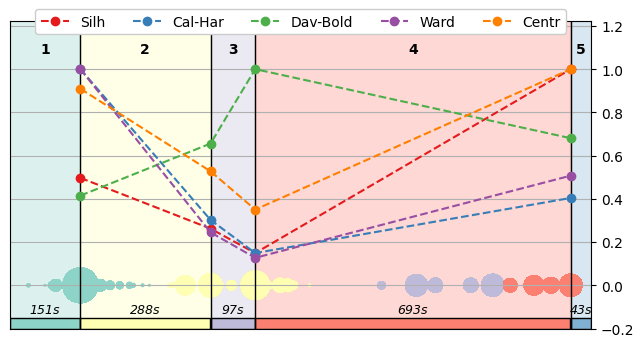

In [135]:
analyze(best_features, 15, "best_topological")

#### Традиционные и топологические вместе + PCA

(1197, 1530)
(1197, 15)
Explained variance 0.6
[0.168, 0.069, 0.048, 0.038, 0.034, 0.032, 0.028, 0.028, 0.025, 0.024, 0.023, 0.022, 0.021, 0.019, 0.019]
Applying to 1197 samples with 15 features each


stage 2: 100%|██████████| 672/672 [00:11<00:00, 56.48it/s]


,St_len_min,K_nb_max,N_cl_max,Cl_cen,Len_min,St_edges,N_stages,Longest_stage,Shortest_stage,Avg_stage_length,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold
0,40,45,20,Median,40,"[0, 145, 426, 874, 1155, 1197]",5,448,42,239.4,34036.494129,17.527894,0.072778,61.620201,3.957016,0.218508,58.097265,3.084954


array([   0,  145,  426,  874, 1155, 1197])

,0,1,2,3,4
"Start-end time, sec","(5.5, 156.5)","(157.5, 459.5)","(460.5, 937.5)","(938.5, 1237.5)","(1238.5, 1281.5)"
"Time length, sec",151.0,302.0,477.0,299.0,43.0
Number of epochs,145,281,448,281,42


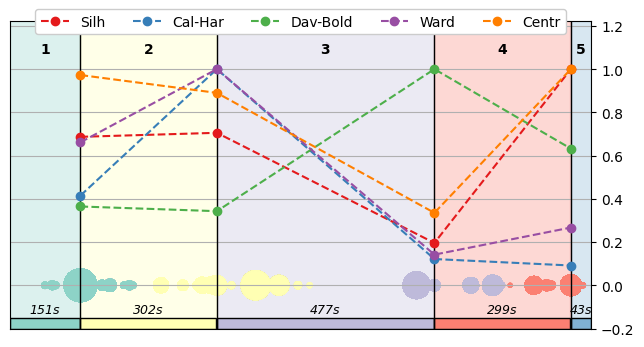

In [136]:
combined_features = pandas.concat([ read_traditional(), best_features ], axis = 1)
analyze(combined_features, 15, "combined")

### Information value

In [137]:
result_edges = numpy.loadtxt(f"{subj}/{exp}/results/best_topological/best_edges.txt").astype(numpy.int32)
print(result_edges)

if os.path.exists(f"{subj}/{exp}/IV/IV.csv"):
    ivs = pandas.read_csv(f"{subj}/{exp}/IV/IV.csv")
else:
    _, labels = SDA.stageprocess.form_stage_bands(result_edges)
    ivs = SDA.analytics.IV.calc_IV_clust(features, labels)

    os.makedirs(f"{subj}/{exp}/IV", exist_ok = True)
    ivs.to_csv(f"{subj}/{exp}/IV/IV.csv", index = False)

ivs["normalized_iv"] = sklearn.preprocessing.MinMaxScaler().fit_transform(ivs[["IV"]])
display(ivs)

[   0  145  413  505 1155 1197]


IV: 100%|██████████| 4172/4172 [00:13<00:00, 318.83it/s]


,Feature,IV,IVs,normalized_iv
0,channel-0 landscape dim-1 max,0.195123,"[0.132623698235551, 0.07800961788019747, 0.116...",0.042977
1,channel-0 landscape dim-1 mean,0.196658,"[0.11973856416958234, 0.02658818870371127, 0.1...",0.043406
2,channel-0 landscape dim-1 std,0.157350,"[0.08852927376114708, 0.05631233709789414, 0.1...",0.032419
3,channel-0 landscape dim-1 sum,0.196658,"[0.11973856416958234, 0.02658818870371127, 0.1...",0.043406
4,channel-0 landscape dim-1 norm-1,0.196658,"[0.11973856416958234, 0.02658818870371127, 0.1...",0.043406
...,...,...,...,...
4167,overall bd2 dim-3 mean,0.197607,"[0.428630444586813, 0.13075137665099282, 0.113...",0.043672
4168,overall bd2 dim-3 std,0.132410,"[0.07957899860128757, 0.02478487166415244, 0.1...",0.025447
4169,overall bd2 dim-3 sum,0.183935,"[0.04905017984268738, 0.13750082189329865, 0.0...",0.039850
4170,overall bd2 dim-3 norm-1,0.183935,"[0.04905017984268738, 0.13750082189329865, 0.0...",0.039850


In [138]:
iv_qsda_scores = scores.join(ivs, lsuffix = "name", rsuffix = "Feature")
iv_qsda_scores = iv_qsda_scores[["name", "unique_values", "score", "normalized_score", "IV", "normalized_iv"]]

iv_qsda_scores["score"] = iv_qsda_scores["score"] * (iv_qsda_scores["unique_values"] >= UNIQUE_VALUES_THRESHOLD)
iv_qsda_scores["normalized_score"] = iv_qsda_scores["normalized_score"] * (iv_qsda_scores["unique_values"] >= UNIQUE_VALUES_THRESHOLD)

iv_qsda_scores = iv_qsda_scores.sort_values(by = 'score', ascending = False)
iv_qsda_scores["QSDA_IDX"] = numpy.arange(1, iv_qsda_scores.shape[0] + 1)

iv_qsda_scores = iv_qsda_scores.sort_values(by = 'IV', ascending = False)
iv_qsda_scores["IV_IDX"] = numpy.arange(1, iv_qsda_scores.shape[0] + 1)

iv_qsda_scores["IDX_DIFF"] = iv_qsda_scores["QSDA_IDX"] - iv_qsda_scores["IV_IDX"]

iv_qsda_scores = iv_qsda_scores.sort_index()
display(iv_qsda_scores)

,name,unique_values,score,normalized_score,IV,normalized_iv,QSDA_IDX,IV_IDX,IDX_DIFF
0,channel-0 landscape dim-1 max,1197,1.095385,0.173895,0.195123,0.042977,2010,1890,120
1,channel-0 landscape dim-1 mean,1197,1.495157,0.241250,0.196658,0.043406,1050,1866,-816
2,channel-0 landscape dim-1 std,1197,1.256457,0.201033,0.157350,0.032419,1602,2394,-792
3,channel-0 landscape dim-1 sum,1197,1.495157,0.241250,0.196658,0.043406,1051,1865,-814
4,channel-0 landscape dim-1 norm-1,1197,1.495157,0.241250,0.196658,0.043406,1052,1864,-812
...,...,...,...,...,...,...,...,...,...
4167,overall bd2 dim-3 mean,1143,1.031630,0.163153,0.197607,0.043672,2158,1846,312
4168,overall bd2 dim-3 std,1083,0.574698,0.086168,0.132410,0.025447,3307,2825,482
4169,overall bd2 dim-3 sum,1143,0.676141,0.103259,0.183935,0.039850,3043,2027,1016
4170,overall bd2 dim-3 norm-1,1143,0.676141,0.103259,0.183935,0.039850,3044,2028,1016


<Axes: >

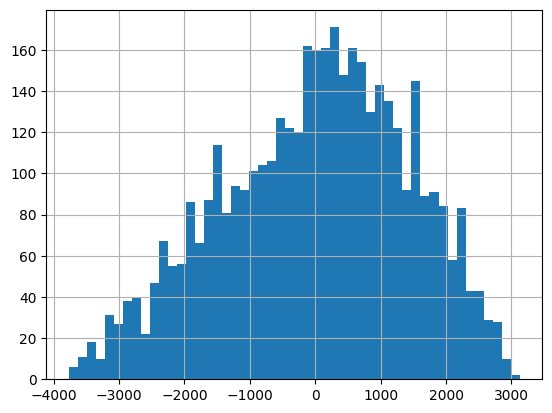

In [139]:
iv_qsda_scores["IDX_DIFF"].hist(bins = 50)

In [140]:
def vec_div(vec):
    mat1 = numpy.repeat(vec.reshape(-1, 1), repeats = len(vec), axis = 1)
    mat2 = numpy.repeat(vec.reshape(1, -1), repeats = len(vec), axis = 0)
    return numpy.sign(mat1 - mat2)

qsda = vec_div(iv_qsda_scores["score"].to_numpy())
iv = vec_div(iv_qsda_scores["IV"].to_numpy())

correct = ((qsda == iv).sum() - iv_qsda_scores.shape[0]) / 2
incorrect = ((qsda != iv).sum() - iv_qsda_scores.shape[0]) / 2

print(correct / 1e6, incorrect / 1e6)

5.207606 3.491014


In [141]:
def sourceFilter(row):
    if row['Source'].startswith('dissim'):
        return 'dissim'
    return row['Source']

iv_qsda_scores[["Source", "Algorithm", "Dimension", "Stat"]] = iv_qsda_scores['name'].str.split(' ', expand = True)
iv_qsda_scores["Source"] = iv_qsda_scores.apply(sourceFilter, axis = 1)
iv_qsda_scores.to_csv(f"{subj}/{exp}/IV/iv_qsda_scores.csv", index = False)

In [142]:
def SourceRenamer(initial: str) -> str:
    if initial == 'dissim':
        return 'Correlations analysis'
    if initial == 'overall':
        return 'Overall processing'
    ind = initial.find('-') + 1
    comp = int(initial[ind:])
    return f'Comp. {comp} (ch. {epochs.ch_names[comp]})'

def AlgorithmRenamer(row):
    return {
        'amplitude-betti-1':        'Betti amp. with p=1',
        'amplitude-betti-2':        'Betti amp. with p=2',

        'amplitude-bottleneck':     'Bottleneck amp.',
        'amplitude-wasserstein-1':  'Wasserstein amp. with p=1',
        'amplitude-wasserstein-2':  'Wasserstein amp. with p=2',
        
        'amplitude-landscape-1-1':  'Pers. landscape amp. with p=1',
        'amplitude-landscape-1-2':  'Pers. landscape amp. with p=1',
        'amplitude-landscape-2-1':  'Pers. landscape amp. with p=2',
        'amplitude-landscape-2-2':  'Pers. landscape amp. with p=2',
        
        'amplitude-silhouette-1-1': 'Pers. silhouette amp. with p=1',
        'amplitude-silhouette-1-2': 'Pers. silhouette amp. with p=1',
        'amplitude-silhouette-2-1': 'Pers. silhouette amp. with p=2',
        'amplitude-silhouette-2-2': 'Pers. silhouette amp. with p=2',

        'bd2':                      'Stat. char. of (b + d) / 2',
        'life':                     'Stat. char. of lifetimes',
        'betti':                    'Stat. char. of Betti curves',
        'landscape':                'Stat. char. of pers. landscape',
        'silhouette-1':             'Stat. char. of lvl 1 pers. silh.',
        'silhouette-2':             'Stat. char. of lvl 2 pers. silh.',
        
        'entropy':                  'Persistence entropy',
        'numberofpoints':           'Number of points',
    }[row]

def DimensionRenamer(row):
    return {
        'all':        'All',
        'dim-1':      'Dimension 1',
        'dim-2':      'Dimension 2',
        'dim-3':      'Dimension 3',
        'dim-4':      'Dimension 4',
        'dim-5':      'Dimension 5',
        'norm-1':     'Amplitude norm with p=1',
        'norm-2':     'Amplitude norm with p=2',
    }[row]

def StatRenamer(row):
    return {
        'kurtosis':      'Kurtosis',
        'skew':          'Skew',
        'max':           'Maximum',
        'mean':          'Mean',
        'median':        'Median',
        'norm-1':        'Norm with p=1',
        'norm-2':        'Norm with p=2',
        'percentile-25': 'Percentile - 25',
        'percentile-75': 'Percentile - 75',
        'std':           'Standard deviation',
        'sum':           'Sum',
    }[row]

def make_stats(data: pandas.DataFrame, group_by: str, sort_by: str):
    stats = data.groupby(by = group_by).mean(numeric_only = True)
    stats = stats.sort_values(by = sort_by).reset_index()
    stats.to_csv(f"{subj}/{exp}/IV/stats_{group_by}_{sort_by}.csv", index = False)
    return stats

def draw(
    data: pandas.DataFrame,
    group_by: str,
    sort_by: str,
    ax,
    renamer: typing.Callable[[str], str],
    title: str
):
    stats = make_stats(data, group_by, sort_by)
    stats[group_by] = stats[group_by].apply(renamer)
    stats.plot.barh(x = group_by, y = sort_by, ax = ax, xlim = (2 * stats[sort_by].min() / 3, None))

    ax.set_title(title)
    ax.get_legend().remove()
    ax.xaxis.set_label_text('')
    ax.yaxis.set_label_text('')

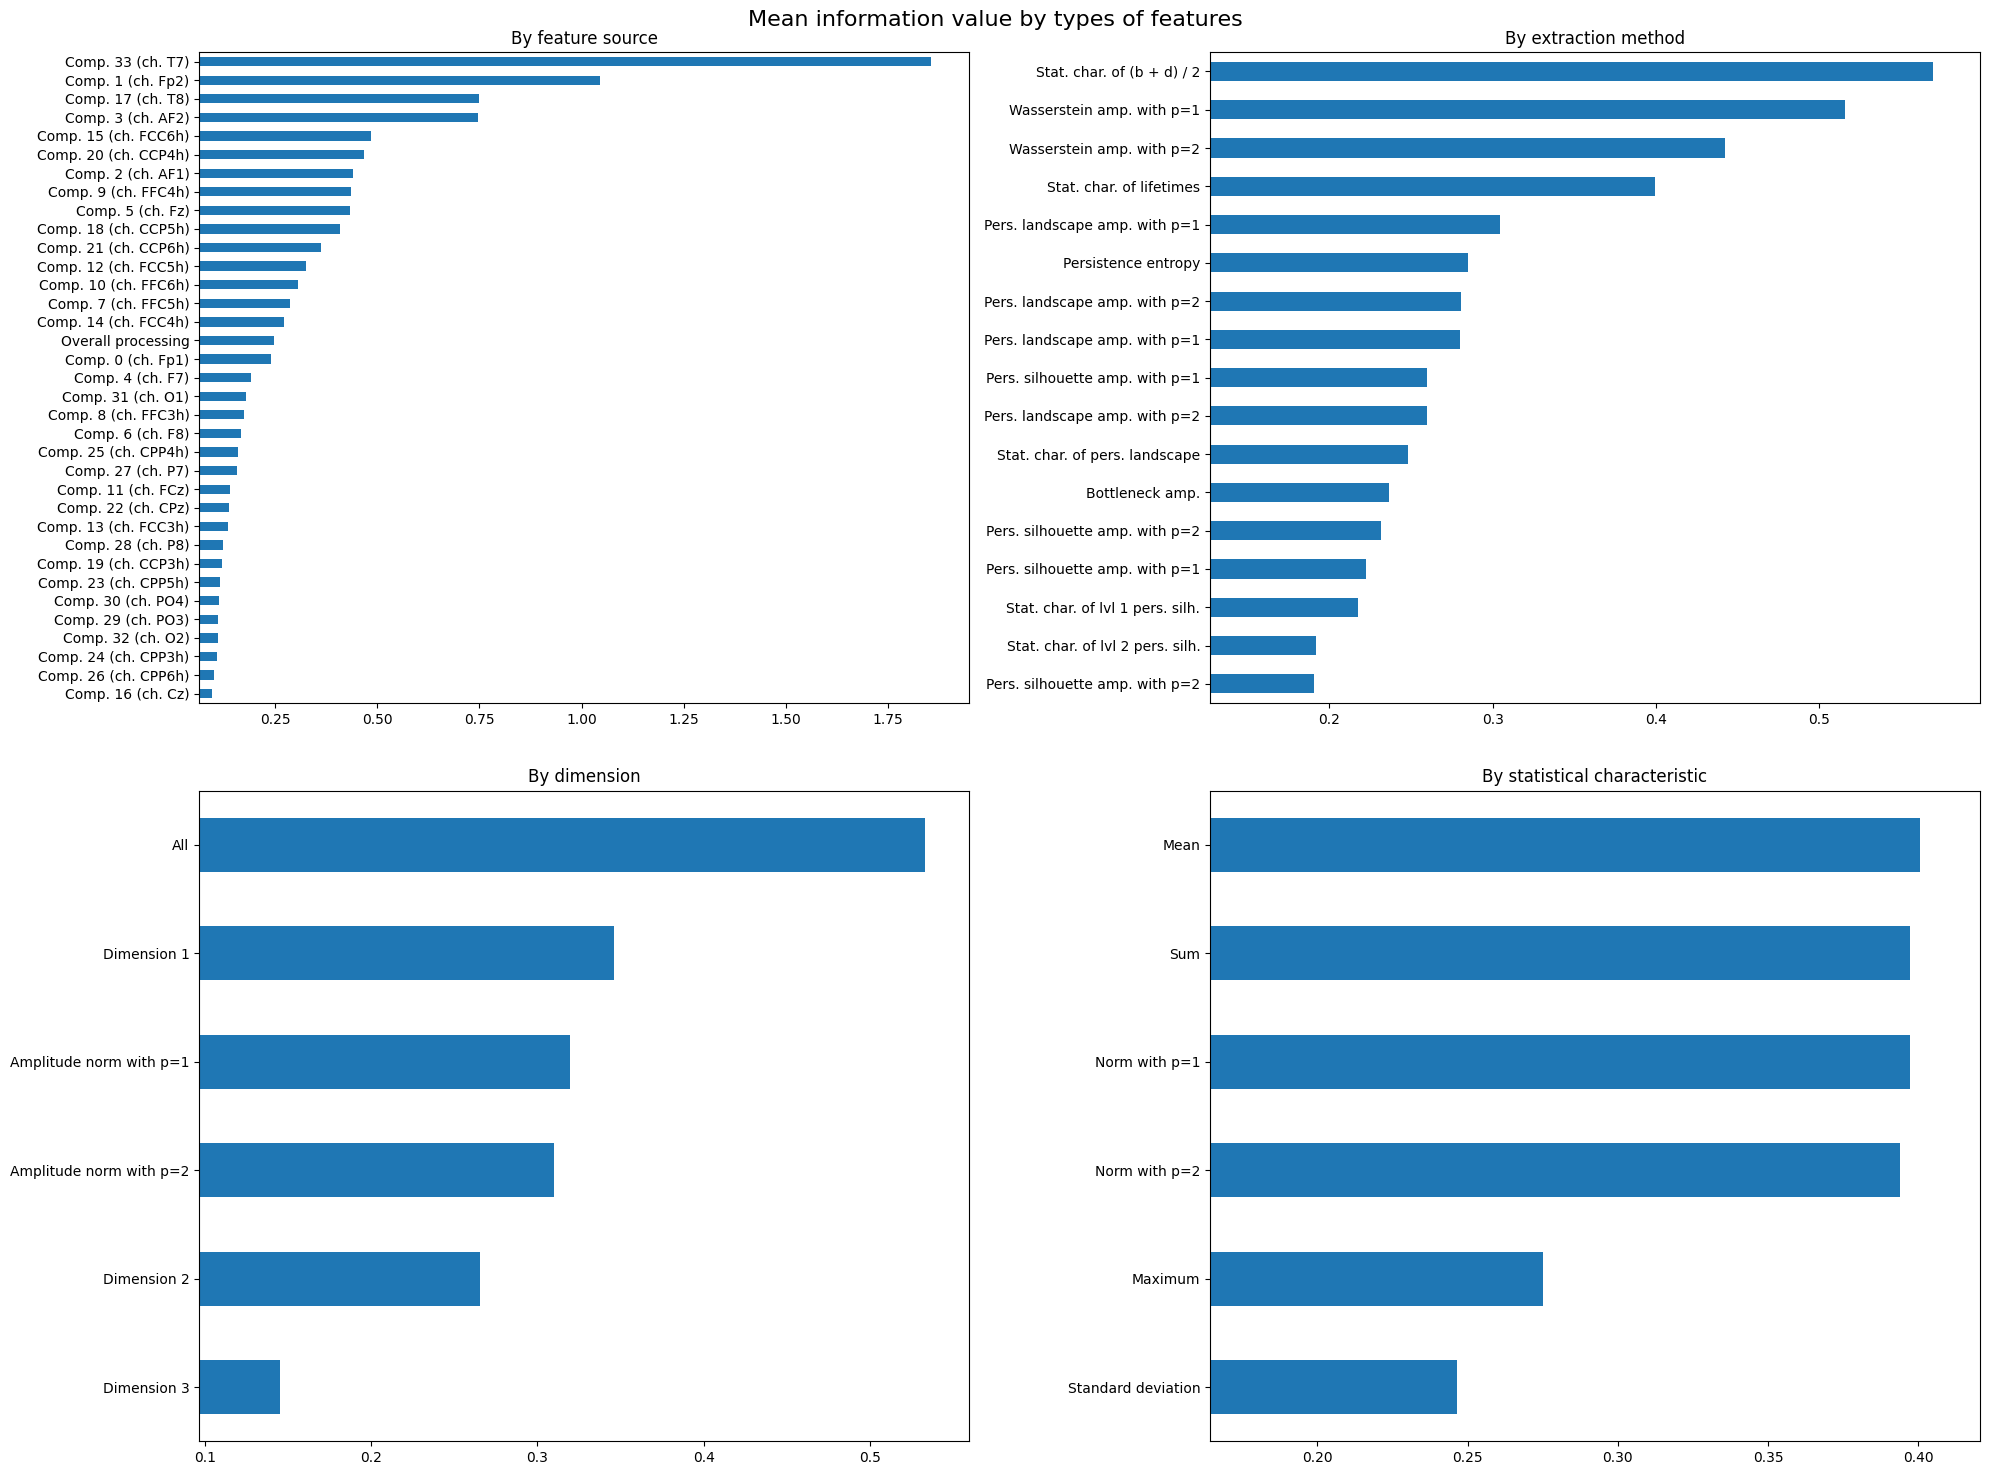

In [143]:
fig, axes = plt.subplots(2, 2, figsize = (20, 15))
fig.suptitle('Mean information value by types of features', fontsize = 16)

draw(iv_qsda_scores, 'Source', 'IV', axes.flat[0], SourceRenamer, 'By feature source')
draw(iv_qsda_scores, 'Algorithm', 'IV', axes.flat[1], AlgorithmRenamer, 'By extraction method')
draw(iv_qsda_scores, 'Dimension', 'IV', axes.flat[2], DimensionRenamer, 'By dimension')
draw(iv_qsda_scores, 'Stat', 'IV', axes.flat[3], StatRenamer, 'By statistical characteristic')

fig.tight_layout(h_pad = 3)
fig.savefig(f"{subj}/{exp}/IV/feature_agg_by_iv.svg")
fig.savefig(f"{subj}/{exp}/IV/feature_agg_by_iv.png")

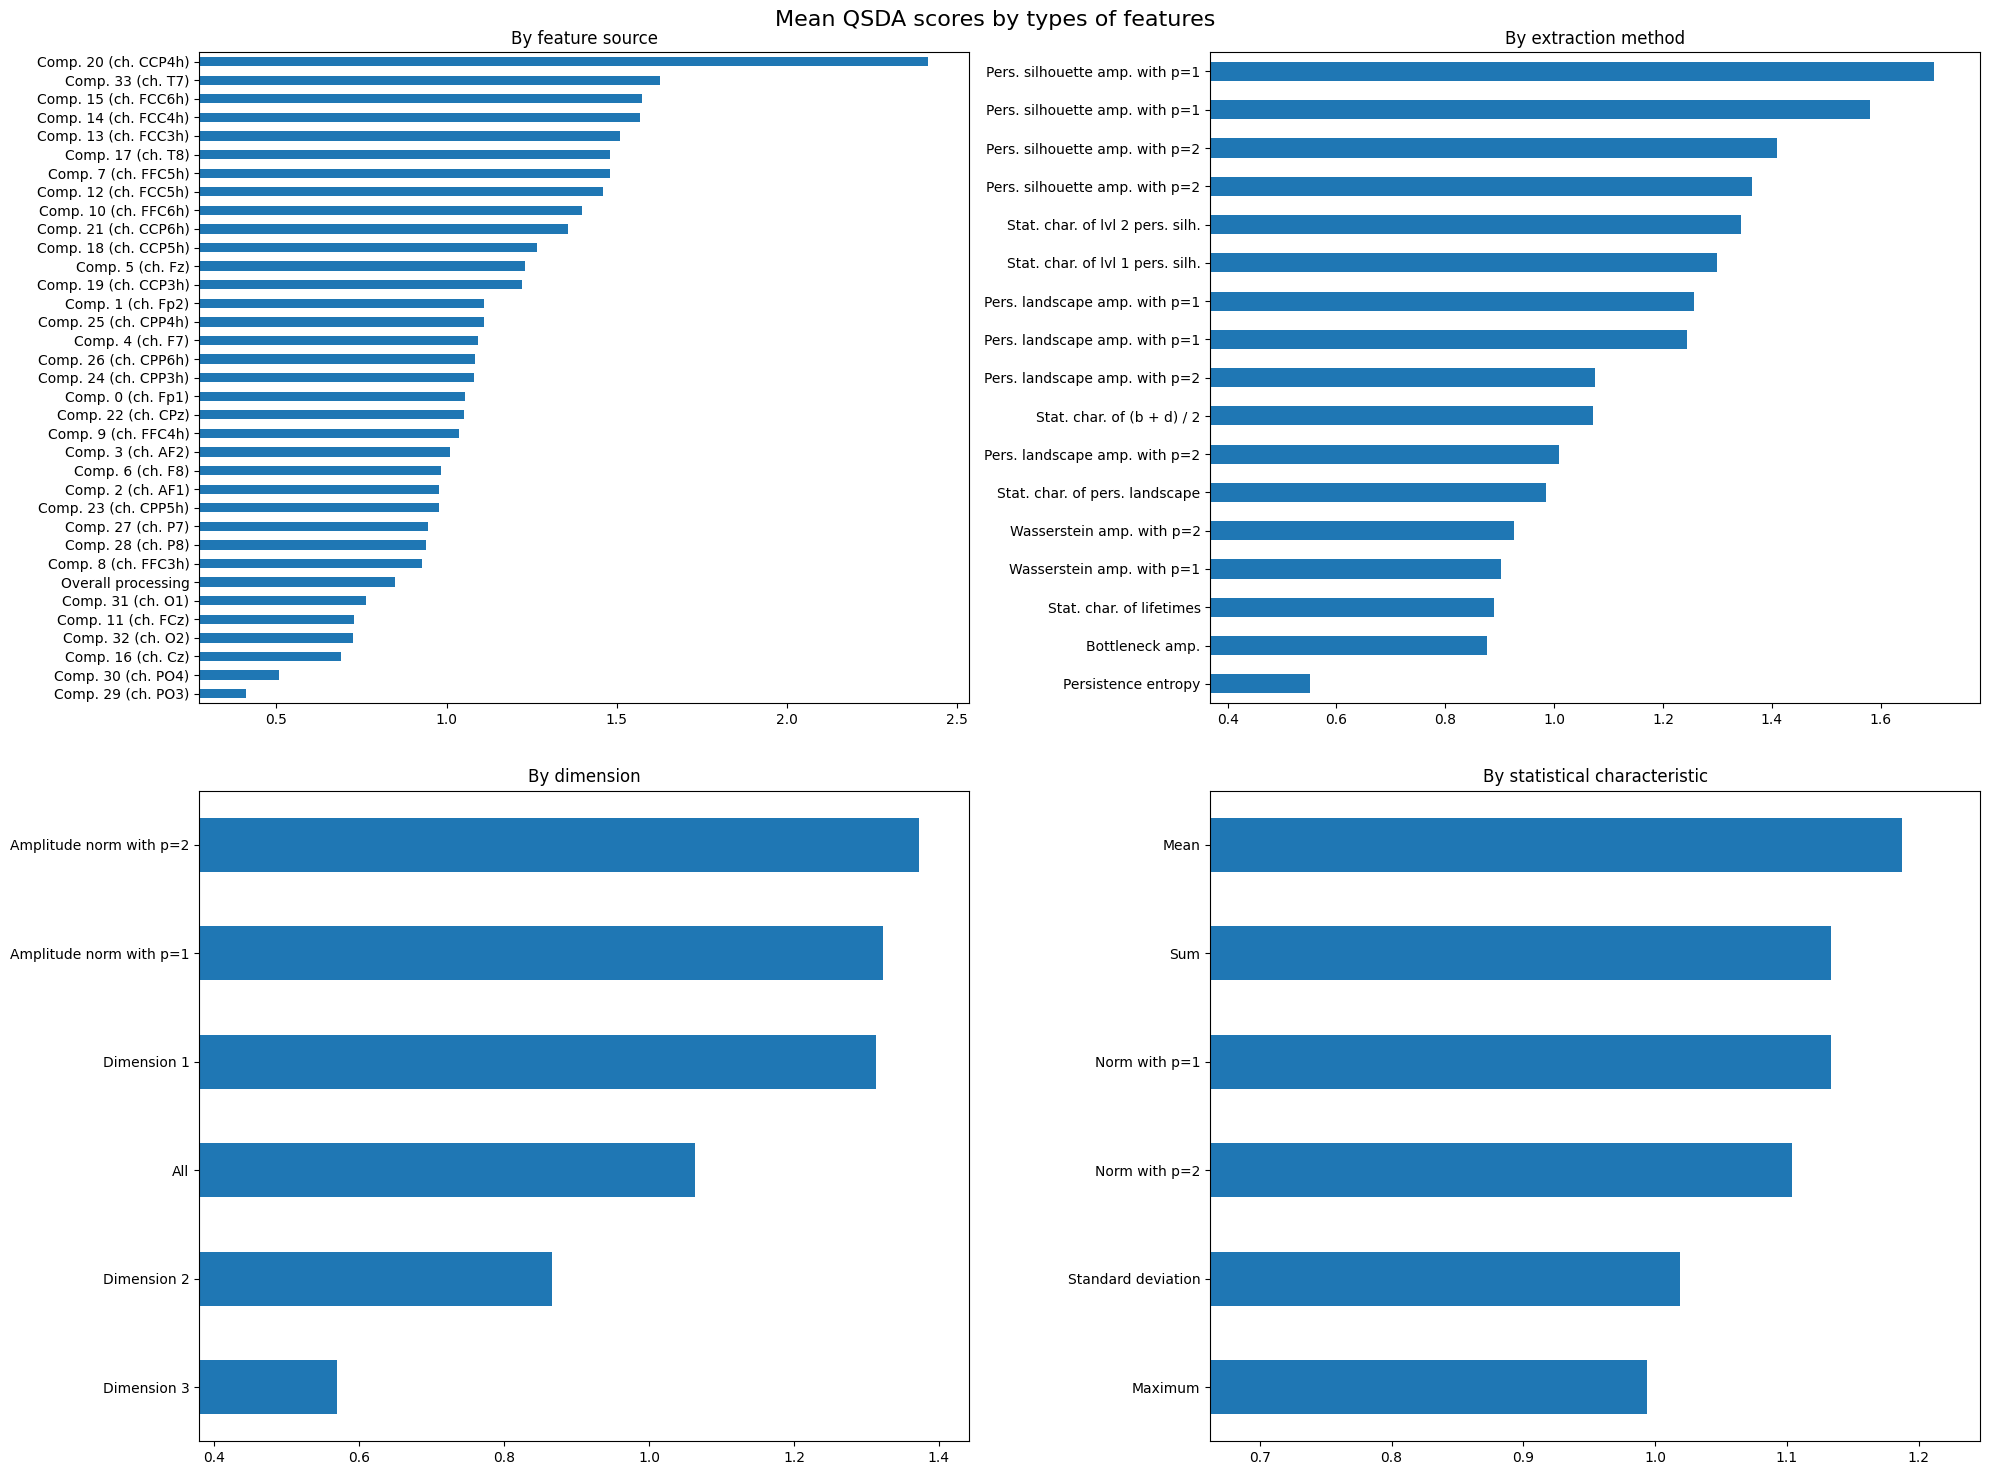

In [144]:
fig, axes = plt.subplots(2, 2, figsize = (20, 15))
fig.suptitle('Mean QSDA scores by types of features', fontsize = 16)

draw(iv_qsda_scores, 'Source', 'score', axes.flat[0], SourceRenamer, 'By feature source')
draw(iv_qsda_scores, 'Algorithm', 'score', axes.flat[1], AlgorithmRenamer, 'By extraction method')
draw(iv_qsda_scores, 'Dimension', 'score', axes.flat[2], DimensionRenamer, 'By dimension')
draw(iv_qsda_scores, 'Stat', 'score', axes.flat[3], StatRenamer, 'By statistical characteristic')

fig.tight_layout(h_pad = 3)
fig.savefig(f"{subj}/{exp}/IV/feature_agg_by_qsda.svg")
fig.savefig(f"{subj}/{exp}/IV/feature_agg_by_qsda.png")

In [145]:
def draw_sources_heatmap(data: pandas.DataFrame, sort_by: str):
    stats = make_stats(data, "Source", sort_by)[["Source", sort_by]]
    stats = stats[stats.apply(lambda row: row['Source'].startswith('channel-'), axis = 1)]

    scores = numpy.zeros(38)
    for _, row in stats.iterrows():
        id = int(row['Source'][row['Source'].find('-') + 1:])
        scores[id] = row[sort_by]

    svg = SDA.analytics.draw_sources_heatmap(scores)
    file = f"{subj}/{exp}/IV/{sort_by}_regions.svg"
    open(file, "w").write(svg)
    return IPython.display.SVG(file)

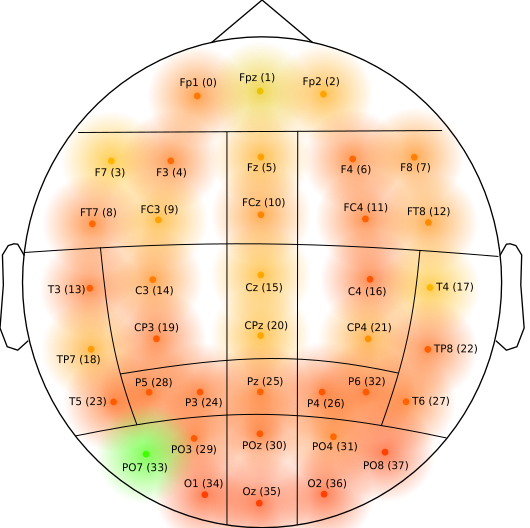

In [146]:
draw_sources_heatmap(iv_qsda_scores, "IV")

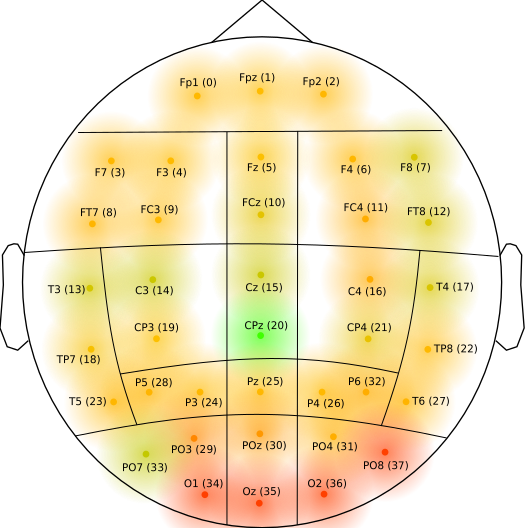

In [147]:
draw_sources_heatmap(iv_qsda_scores, "score")